## Library

In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

## Problem 1

### 1-1

activation function, loss function

In [19]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    epsilon = 1e-12  # Avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    return -np.mean(np.log(y_pred[np.arange(len(y_true)), y_true]))

Forward, backward pass and evaluate accuracy

In [3]:
def forward(x, weights, biases):
    zs, activations = [], [x]
    for i in range(len(weights)):
        z = np.dot(activations[-1], weights[i]) + biases[i]
        zs.append(z)

        if i < len(weights) -1:
            a = relu(z)
        else:
            a = softmax(z)
        activations.append(a)
    return zs, activations

def backward(x, y_true, zs, activations, weights, biases, learning_rate):
    L = len(weights)
    batch_size = x.shape[0]
    
    grads_w = [None] * L
    grads_b = [None] * L

    y_pred = activations[-1]
    delta = y_pred.copy()
    delta[np.arange(batch_size), y_true] -= 1
    delta /= batch_size
    
    grads_w[-1] = np.dot(activations[L-1].T, delta)
    grads_b[-1] = np.sum(delta, axis=0, keepdims=True)

    for l in range(L-2, -1, -1):
        delta = np.dot(delta, weights[l+1].T) * relu_derivative(zs[l])
        grads_w[l] = np.dot(activations[l].T, delta)
        grads_b[l] = np.sum(delta, axis=0, keepdims=True)

    for i in range(L):
        weights[i] -= learning_rate * grads_w[i]
        biases[i] -= learning_rate * grads_b[i]

def evaluate(x, y_true, weights, biases):
    _, activations = forward(x, weights, biases)
    predictions = np.argmax(activations[-1], axis=1)
    accuracy = np.mean(predictions == y_true)

    return accuracy

Train the model and track accuracy every 30 iterations

In [10]:
def train_model(train_x, train_y, test_x, test_y, weights, biases, epochs=30, batch_size=200, lr=0.005):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    num_batches = train_x.shape[0] // batch_size
    step = 0
    for epoch in range(epochs):
        for i in range(0, train_x.shape[0], batch_size):
            xb = train_x[i:i+batch_size]
            yb = train_y[i:i+batch_size]

            zs, activations = forward(xb, weights, biases)
            loss = cross_entropy_loss(activations[-1], yb)
            backward(xb, yb, zs, activations, weights, biases, lr)

            if step % 30 == 0:
                _, train_activations = forward(train_x, weights, biases)
                train_loss = cross_entropy_loss(train_activations[-1], train_y)
                train_acc = evaluate(train_x, train_y, weights, biases)

                _, test_activations = forward(test_x, weights, biases)
                test_loss = cross_entropy_loss(test_activations[-1], test_y)
                test_acc = evaluate(test_x, test_y, weights, biases)

                train_losses.append(train_loss)
                test_losses.append(test_loss)
                train_accs.append(train_acc)
                test_accs.append(test_acc)
                print(f"[Iter {step}] Train Loss: {train_loss:.4f} | Val Loss: {test_loss:.4f} | "
                      f"Train Acc: {train_acc:.4f} | Val Acc: {test_acc:.4f}")
            step += 1
        print(f"Epoch {epoch+1}: Loss = {loss:.4f}")
    final_train_loss = cross_entropy_loss(forward(train_x, weights, biases)[1][-1], train_y)
    final_test_loss = cross_entropy_loss(forward(test_x, weights, biases)[1][-1], test_y)
    final_train_acc = evaluate(train_x, train_y, weights, biases)
    final_test_acc = evaluate(test_x, test_y, weights, biases)

    print("\nFinal Results:")
    print(f"Train Loss: {final_train_loss:.4f} | Train Accuracy: {final_train_acc:.4f}")
    print(f"Val  Loss: {final_test_loss:.4f} | Val  Accuracy: {final_test_acc:.4f}")

    return train_losses, test_losses, train_accs, test_accs



function for plotting learning curves

In [6]:
def plot_learning_curves(train_losses, test_losses, train_accs, test_accs):
    x = np.arange(len(train_losses)) * 30  # iteration steps

    plt.figure()
    plt.plot(x, train_losses, label="Train Loss")
    plt.plot(x, test_losses, label="Val Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Cross-Entropy Loss vs Iteration")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(x, train_accs, label="Train Accuracy")
    plt.plot(x, test_accs, label="Val Accuracy")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Iteration")
    plt.legend()
    plt.grid(True)
    plt.show()

#### (a) prepare data and initialize network parameters from weight.npy

[Iter 0] Train Loss: 20.4072 | Val Loss: 20.4738 | Train Acc: 0.2575 | Val Acc: 0.2552
[Iter 30] Train Loss: 7.4697 | Val Loss: 7.7145 | Train Acc: 0.7158 | Val Acc: 0.7073
[Iter 60] Train Loss: 6.9096 | Val Loss: 7.2789 | Train Acc: 0.7292 | Val Acc: 0.7154
[Iter 90] Train Loss: 6.2848 | Val Loss: 6.6802 | Train Acc: 0.7472 | Val Acc: 0.7338
[Iter 120] Train Loss: 5.6598 | Val Loss: 6.0948 | Train Acc: 0.7666 | Val Acc: 0.7504
[Iter 150] Train Loss: 5.6204 | Val Loss: 6.0667 | Train Acc: 0.7615 | Val Acc: 0.7465
[Iter 180] Train Loss: 5.4398 | Val Loss: 5.9554 | Train Acc: 0.7600 | Val Acc: 0.7414
[Iter 210] Train Loss: 5.2133 | Val Loss: 5.6819 | Train Acc: 0.7651 | Val Acc: 0.7507
[Iter 240] Train Loss: 5.1402 | Val Loss: 5.6059 | Train Acc: 0.7567 | Val Acc: 0.7402
[Iter 270] Train Loss: 4.8073 | Val Loss: 5.2775 | Train Acc: 0.7609 | Val Acc: 0.7431
Epoch 1: Loss = 5.0242
[Iter 300] Train Loss: 4.5638 | Val Loss: 5.0272 | Train Acc: 0.7667 | Val Acc: 0.7484
[Iter 330] Train Loss: 

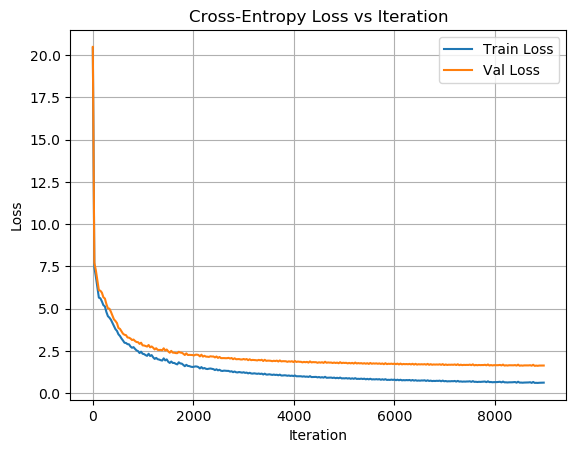

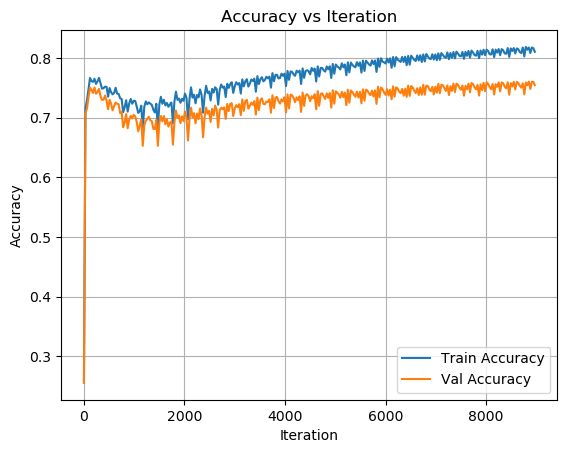

In [14]:
train_x = np.load('./fashion/train_x.npy') / 255.0
train_y = np.load('./fashion/train_y.npy')
test_x = np.load('./fashion/test_x.npy') / 255.0
test_y = np.load('./fashion/test_y.npy')

train_x = train_x.reshape(train_x.shape[0], -1)
test_x = test_x.reshape(test_x.shape[0], -1)

weights_data = np.load("weights.npy", allow_pickle=True).item()

weights = [weights_data[f"w{i+1}"] for i in range(3)]
biases  = [weights_data[f"b{i+1}"].reshape(1, -1) for i in range(3)]

train_losses, test_losses, train_accs, test_accs = train_model(train_x, train_y, test_x, test_y, weights, biases)

plot_learning_curves(train_losses, test_losses, train_accs, test_accs)

#### (b) prepare data and initialize network parameters with zero

[Iter 0] Train Loss: 2.3026 | Val Loss: 2.3026 | Train Acc: 0.1000 | Val Acc: 0.1000
[Iter 30] Train Loss: 2.3026 | Val Loss: 2.3026 | Train Acc: 0.1000 | Val Acc: 0.1000
[Iter 60] Train Loss: 2.3026 | Val Loss: 2.3026 | Train Acc: 0.1000 | Val Acc: 0.1000
[Iter 90] Train Loss: 2.3026 | Val Loss: 2.3026 | Train Acc: 0.1000 | Val Acc: 0.1000
[Iter 120] Train Loss: 2.3026 | Val Loss: 2.3026 | Train Acc: 0.1000 | Val Acc: 0.1000
[Iter 150] Train Loss: 2.3026 | Val Loss: 2.3026 | Train Acc: 0.1000 | Val Acc: 0.1000
[Iter 180] Train Loss: 2.3026 | Val Loss: 2.3026 | Train Acc: 0.1000 | Val Acc: 0.1000
[Iter 210] Train Loss: 2.3026 | Val Loss: 2.3026 | Train Acc: 0.1000 | Val Acc: 0.1000
[Iter 240] Train Loss: 2.3026 | Val Loss: 2.3026 | Train Acc: 0.1000 | Val Acc: 0.1000
[Iter 270] Train Loss: 2.3026 | Val Loss: 2.3026 | Train Acc: 0.1000 | Val Acc: 0.1000
Epoch 1: Loss = 2.3026
[Iter 300] Train Loss: 2.3026 | Val Loss: 2.3026 | Train Acc: 0.1000 | Val Acc: 0.1000
[Iter 330] Train Loss: 2.

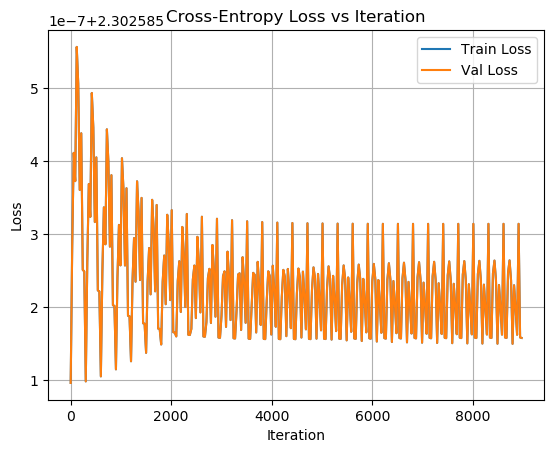

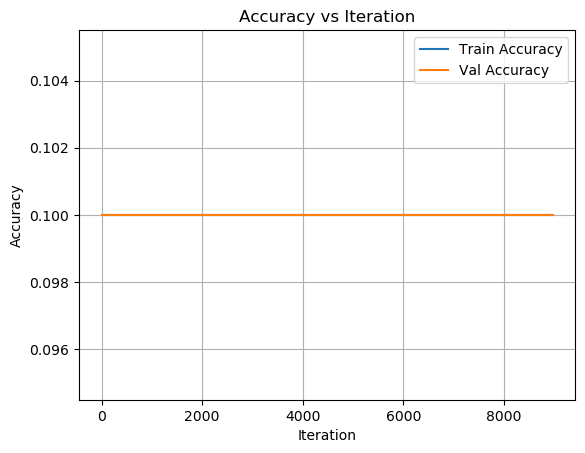

In [15]:
train_x = np.load('./fashion/train_x.npy') / 255.0
train_y = np.load('./fashion/train_y.npy')
test_x = np.load('./fashion/test_x.npy') / 255.0
test_y = np.load('./fashion/test_y.npy')

train_x = train_x.reshape(train_x.shape[0], -1)
test_x = test_x.reshape(test_x.shape[0], -1)

layer_sizes = [784, 2048, 512, 10]

weights = [np.zeros((layer_sizes[i], layer_sizes[i+1])) for i in range(3)]
biases  = [np.zeros((1, layer_sizes[i+1])) for i in range(3)]

train_losses, test_losses, train_accs, test_accs = train_model(train_x, train_y, test_x, test_y, weights, biases)

plot_learning_curves(train_losses, test_losses, train_accs, test_accs)


#### problem1-1 discussion

##### Analysis of Weight Initialization Impact on Model Performance

Without changing the model structure or configuration, we observed a significant performance gap between two versions of the model:

- **Zero-initialized model**:
Final test accuracy is **poor**.

- **Model initialized with `weights.npy`**:
Achieves a final test accuracy of **0.76**.

##### Training Loss Comparison

- The **zero-initialized model** starts with a relatively low loss of **2.036**.

- The **non-zero-initialized model** starts with a higher loss of **20.4072**, but its loss **continues to decrease and eventually converges**.

  In contrast, the zero-initialized model’s loss remains **nearly constant** throughout the training process.

##### Interpretation

This behavior suggests that:

- The **zero-initialized model** gets stuck in a **poor local minimum** early in training.

- It **fails to escape** this local minimum, resulting in **suboptimal learning**.

- This is **undesirable**, as our objective is to reach the **global minimum** to ensure better generalization and performance.

### 1-2

#### (a) forward, backward propagation and evaluate with dropout

In [7]:
def forward(x, weights, biases, dropout_rate=0.2, training=True):
    zs, activations = [], [x]
    dropout_masks = []
    for i in range(len(weights)):
        z = np.dot(activations[-1], weights[i]) + biases[i]
        zs.append(z)

        if i < len(weights) -1:
            a = relu(z)
            if training and i < 2:
                mask = (np.random.rand(*a.shape) > dropout_rate).astype(float)
                a *= mask
                a /= (1.0 - dropout_rate)
                dropout_masks.append(mask)
            else:
                dropout_masks.append(None)
        else:
            a = softmax(z)
            dropout_masks.append(None)
        activations.append(a)
    return zs, activations, dropout_masks

def backward(x, y_true, zs, activations, dropout_masks, weights, biases, learning_rate):
    L = len(weights)
    batch_size = x.shape[0]
    
    grads_w = [None] * L
    grads_b = [None] * L

    y_pred = activations[-1]

    delta = y_pred.copy()
    delta[np.arange(batch_size), y_true] -= 1
    delta /= batch_size
    
    grads_w[-1] = np.dot(activations[L-1].T, delta)
    grads_b[-1] = np.sum(delta, axis=0, keepdims=True)

    for l in range(L-2, -1, -1):
        delta = np.dot(delta, weights[l+1].T) * relu_derivative(zs[l])

        if dropout_masks[l] is not None:
            delta *= dropout_masks[l]

        grads_w[l] = np.dot(activations[l].T, delta)
        grads_b[l] = np.sum(delta, axis=0, keepdims=True)

    for i in range(L):
        weights[i] -= learning_rate * grads_w[i]
        biases[i] -= learning_rate * grads_b[i]

def evaluate(x, y_true, weights, biases):
    _, activations, __annotations__ = forward(x, weights, biases, training=False)
    predictions = np.argmax(activations[-1], axis=1)
    accuracy = np.mean(predictions == y_true)

    return accuracy

training call with dropout

In [10]:
def train_model(train_x, train_y, test_x, test_y, weights, biases, epochs=30, batch_size=200, lr=0.005):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    num_batches = train_x.shape[0] // batch_size
    step = 0
    for epoch in range(epochs):
        for i in range(0, train_x.shape[0], batch_size):
            xb = train_x[i:i+batch_size]
            yb = train_y[i:i+batch_size]

            zs, activations, dropout_masks = forward(xb, weights, biases, training=True)
            loss = cross_entropy_loss(activations[-1], yb)
            backward(xb, yb, zs, activations, dropout_masks, weights, biases, lr)

            if step % 30 == 0:
                _, train_activations, _ = forward(train_x, weights, biases, training=False)
                train_loss = cross_entropy_loss(train_activations[-1], train_y)
                train_acc = evaluate(train_x, train_y, weights, biases)

                _, test_activations, _ = forward(test_x, weights, biases, training=False)
                test_loss = cross_entropy_loss(test_activations[-1], test_y)
                test_acc = evaluate(test_x, test_y, weights, biases)

                train_losses.append(train_loss)
                test_losses.append(test_loss)
                train_accs.append(train_acc)
                test_accs.append(test_acc)
                print(f"[Iter {step}] Train Loss: {train_loss:.4f} | Val Loss: {test_loss:.4f} | "
                      f"Train Acc: {train_acc:.4f} | Val Acc: {test_acc:.4f}")
            step += 1
        print(f"Epoch {epoch+1}: Loss = {loss:.4f}")
    final_train_loss = cross_entropy_loss(forward(train_x, weights, biases)[1][-1], train_y)
    final_test_loss = cross_entropy_loss(forward(test_x, weights, biases)[1][-1], test_y)
    final_train_acc = evaluate(train_x, train_y, weights, biases)
    final_test_acc = evaluate(test_x, test_y, weights, biases)

    print("\nFinal Results:")
    print(f"Train Loss: {final_train_loss:.4f} | Train Accuracy: {final_train_acc:.4f}")
    print(f"Val  Loss: {final_test_loss:.4f} | Val  Accuracy: {final_test_acc:.4f}")

    return train_losses, test_losses, train_accs, test_accs

training the model with dropout layers

[Iter 0] Train Loss: 20.6873 | Val Loss: 20.7577 | Train Acc: 0.2472 | Val Acc: 0.2445
[Iter 30] Train Loss: 7.4899 | Val Loss: 7.7811 | Train Acc: 0.7205 | Val Acc: 0.7101
[Iter 60] Train Loss: 5.9425 | Val Loss: 6.2431 | Train Acc: 0.7756 | Val Acc: 0.7650
[Iter 90] Train Loss: 6.1421 | Val Loss: 6.4109 | Train Acc: 0.7656 | Val Acc: 0.7570
[Iter 120] Train Loss: 5.9547 | Val Loss: 6.2686 | Train Acc: 0.7710 | Val Acc: 0.7579
[Iter 150] Train Loss: 5.9128 | Val Loss: 6.1969 | Train Acc: 0.7679 | Val Acc: 0.7577
[Iter 180] Train Loss: 5.6079 | Val Loss: 5.8641 | Train Acc: 0.7700 | Val Acc: 0.7585
[Iter 210] Train Loss: 5.8410 | Val Loss: 6.0839 | Train Acc: 0.7611 | Val Acc: 0.7491
[Iter 240] Train Loss: 5.5595 | Val Loss: 5.8164 | Train Acc: 0.7618 | Val Acc: 0.7517
[Iter 270] Train Loss: 4.7890 | Val Loss: 5.0026 | Train Acc: 0.7756 | Val Acc: 0.7662
Epoch 1: Loss = 8.4003
[Iter 300] Train Loss: 5.2633 | Val Loss: 5.5048 | Train Acc: 0.7562 | Val Acc: 0.7428
[Iter 330] Train Loss: 

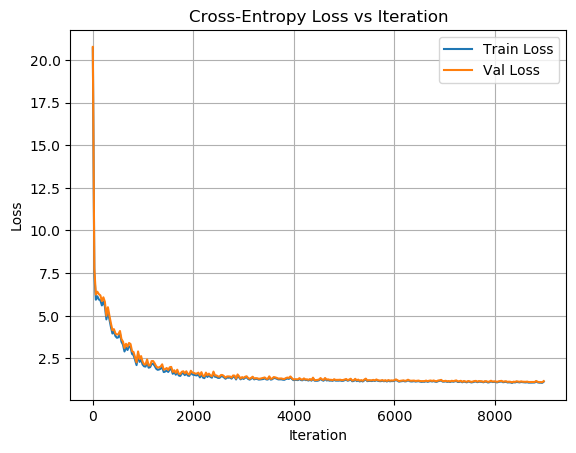

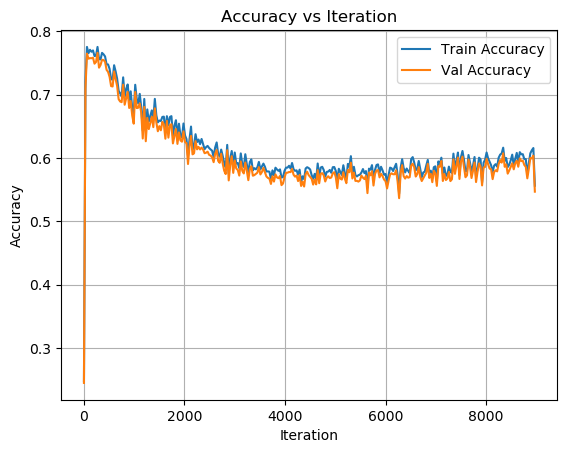

In [11]:
train_x = np.load('./fashion/train_x.npy') / 255.0
train_y = np.load('./fashion/train_y.npy')
test_x = np.load('./fashion/test_x.npy') / 255.0
test_y = np.load('./fashion/test_y.npy')

train_x = train_x.reshape(train_x.shape[0], -1)
test_x = test_x.reshape(test_x.shape[0], -1)

weights_data = np.load("weights.npy", allow_pickle=True).item()

weights = [weights_data[f"w{i+1}"] for i in range(3)]
biases  = [weights_data[f"b{i+1}"].reshape(1, -1) for i in range(3)]

train_losses, test_losses, train_accs, test_accs = train_model(train_x, train_y, test_x, test_y, weights, biases)

plot_learning_curves(train_losses, test_losses, train_accs, test_accs)

#### problem1-2 discussion

##### Dropout effect summary
- After adding dropout layers after the first two hidden layers:

    The **overall model accuracy** slightly **decreased** compared to the version **without dropout**.
    
    However, the **gap between training and testing accuracy** became **significantly smaller**.

- Conclusion

    Although dropout reduced the final accuracy slightly, it successfully helped mitigate **overfitting**, resulting in a more **generalizable** model. 

    This trade-off is expected behavior since dropout acts as a regularization technique that prevents the model from relying too heavily on specific neurons during training.

### 1-3

#### (a) forward, backward and evaluate functions based on 1-1.

In [13]:
def forward(x, weights, biases):
    zs, activations = [], [x]
    for i in range(len(weights)):
        z = np.dot(activations[-1], weights[i]) + biases[i]
        zs.append(z)

        if i < len(weights) -1:
            a = relu(z)
        else:
            a = softmax(z)
        activations.append(a)
    return zs, activations

def backward(x, y_true, zs, activations, weights, biases, learning_rate):
    L = len(weights)
    batch_size = x.shape[0]
    
    grads_w = [None] * L
    grads_b = [None] * L

    y_pred = activations[-1]
    delta = y_pred.copy()
    delta[np.arange(batch_size), y_true] -= 1
    delta /= batch_size
    
    grads_w[-1] = np.dot(activations[L-1].T, delta)
    grads_b[-1] = np.sum(delta, axis=0, keepdims=True)

    for l in range(L-2, -1, -1):
        delta = np.dot(delta, weights[l+1].T) * relu_derivative(zs[l])
        grads_w[l] = np.dot(activations[l].T, delta)
        grads_b[l] = np.sum(delta, axis=0, keepdims=True)

    for i in range(L):
        weights[i] -= learning_rate * grads_w[i]
        biases[i] -= learning_rate * grads_b[i]

def evaluate(x, y_true, weights, biases):
    _, activations = forward(x, weights, biases)
    predictions = np.argmax(activations[-1], axis=1)
    accuracy = np.mean(predictions == y_true)

    return accuracy

train function with reshuffled mini batches. 

In [20]:
def train_model(train_x, train_y, test_x, test_y, weights, biases, epochs=30, batch_size=200, lr=0.005):
    random.seed(42)
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    step = 0
    for epoch in range(epochs):
        indices = list(range(train_x.shape[0]))
        random.shuffle(indices)
        train_x = train_x[indices]
        train_y = train_y[indices]
        for i in range(0, train_x.shape[0], batch_size):
            xb = train_x[i:i+batch_size]
            yb = train_y[i:i+batch_size]

            zs, activations = forward(xb, weights, biases)
            loss = cross_entropy_loss(activations[-1], yb)
            backward(xb, yb, zs, activations, weights, biases, lr)

            if step % 30 == 0:
                _, train_activations = forward(train_x, weights, biases)
                train_loss = cross_entropy_loss(train_activations[-1], train_y)
                train_acc = evaluate(train_x, train_y, weights, biases)

                _, test_activations = forward(test_x, weights, biases)
                test_loss = cross_entropy_loss(test_activations[-1], test_y)
                test_acc = evaluate(test_x, test_y, weights, biases)

                train_losses.append(train_loss)
                test_losses.append(test_loss)
                train_accs.append(train_acc)
                test_accs.append(test_acc)
                print(f"[Iter {step}] Train Loss: {train_loss:.4f} | Val Loss: {test_loss:.4f} | "
                      f"Train Acc: {train_acc:.4f} | Val Acc: {test_acc:.4f}")
            step += 1
        print(f"Epoch {epoch+1}: Loss = {loss:.4f}")
    final_train_loss = cross_entropy_loss(forward(train_x, weights, biases)[1][-1], train_y)
    final_test_loss = cross_entropy_loss(forward(test_x, weights, biases)[1][-1], test_y)
    final_train_acc = evaluate(train_x, train_y, weights, biases)
    final_test_acc = evaluate(test_x, test_y, weights, biases)

    print("\nFinal Results:")
    print(f"Train Loss: {final_train_loss:.4f} | Train Accuracy: {final_train_acc:.4f}")
    print(f"Val  Loss: {final_test_loss:.4f} | Val  Accuracy: {final_test_acc:.4f}")

    return train_losses, test_losses, train_accs, test_accs

train the model with shuffling

[Iter 0] Train Loss: 23.4090 | Val Loss: 23.3163 | Train Acc: 0.1503 | Val Acc: 0.1525
[Iter 30] Train Loss: 7.3985 | Val Loss: 7.7833 | Train Acc: 0.7135 | Val Acc: 0.7004
[Iter 60] Train Loss: 7.4604 | Val Loss: 7.7759 | Train Acc: 0.7048 | Val Acc: 0.6947
[Iter 90] Train Loss: 6.5662 | Val Loss: 6.8690 | Train Acc: 0.7337 | Val Acc: 0.7218
[Iter 120] Train Loss: 5.9699 | Val Loss: 6.3362 | Train Acc: 0.7431 | Val Acc: 0.7301
[Iter 150] Train Loss: 5.8319 | Val Loss: 6.1764 | Train Acc: 0.7386 | Val Acc: 0.7249
[Iter 180] Train Loss: 5.3883 | Val Loss: 5.6826 | Train Acc: 0.7492 | Val Acc: 0.7389
[Iter 210] Train Loss: 5.2170 | Val Loss: 5.5843 | Train Acc: 0.7426 | Val Acc: 0.7273
[Iter 240] Train Loss: 4.8606 | Val Loss: 5.1984 | Train Acc: 0.7468 | Val Acc: 0.7322
[Iter 270] Train Loss: 4.7199 | Val Loss: 5.0108 | Train Acc: 0.7423 | Val Acc: 0.7277
Epoch 1: Loss = 4.5840
[Iter 300] Train Loss: 4.5327 | Val Loss: 4.8992 | Train Acc: 0.7291 | Val Acc: 0.7130
[Iter 330] Train Loss: 

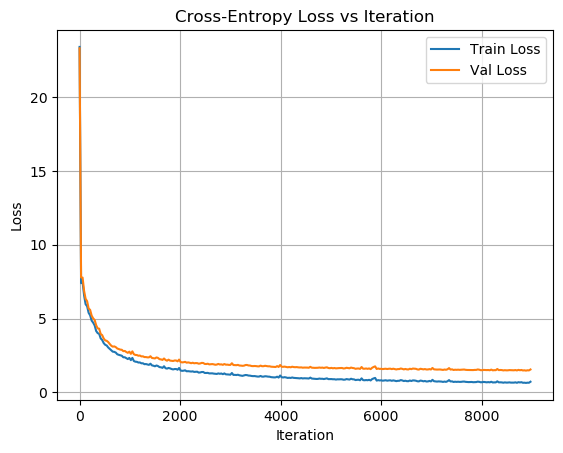

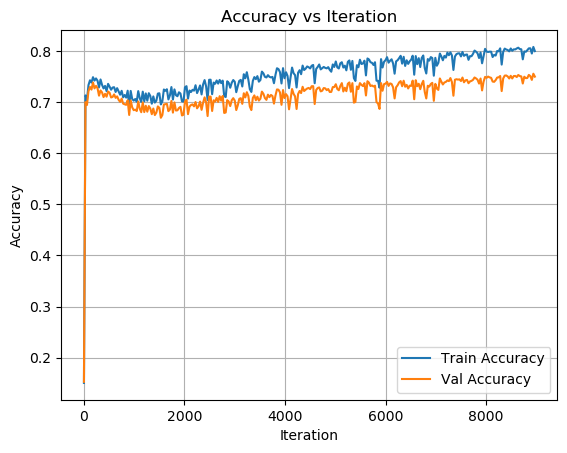

In [21]:
train_x = np.load('./fashion/train_x.npy') / 255.0
train_y = np.load('./fashion/train_y.npy')
test_x = np.load('./fashion/test_x.npy') / 255.0
test_y = np.load('./fashion/test_y.npy')

train_x = train_x.reshape(train_x.shape[0], -1)
test_x = test_x.reshape(test_x.shape[0], -1)

weights_data = np.load("weights.npy", allow_pickle=True).item()

weights = [weights_data[f"w{i+1}"] for i in range(3)]
biases  = [weights_data[f"b{i+1}"].reshape(1, -1) for i in range(3)]

train_losses, test_losses, train_accs, test_accs = train_model(train_x, train_y, test_x, test_y, weights, biases)

plot_learning_curves(train_losses, test_losses, train_accs, test_accs)

#### problem1-3 discussion

##### Reshuffling training data during training using SGD can help in:

- Improving generalization

    If the same order is used in every epoch, the model may overfit to the **patters in the batch sequence**, leading to poor generalization.
  
    In this problem, infering that the model **doesn't overfit** to such patters when reshuffling is applied, as the **accuracy on the test dataset did not degrade**.
  
- Accelerating convergence

    Reshuffling allows the model to experience a more diverse set of mini-batches in each epoch, giving it a better chance to **escape lobal minima** and **converge faster**.

    From the accuracy plots of **1-1 (no reshuffling)** and **1-3 (with reshuffling)**, we can se that **1-3 shows slightly faster convergence**. 

- Regularization
  
    Reshuffling has a regularization effect, similar to dropout, by reducing the model's dependency on specific data sequences.

    The difference in loss between training and test datasets is **smaller in 1-3 (0.8389)** compared to **1-1 (1.009)**.

    Test losses in **1-2 (1.4113)** and **1-3 (1.4774)** are both lower than in **1-1 (1.6367)**, showing improved generalization.

## Problem 2

### Libraries

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import matplotlib.pyplot as plt

### 2-1

prepare dataset and device

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dir = "./flower/train"
test_dir = "./flower/test"

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class TestFlowerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith(".jpg")])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]
    
test_dataset = TestFlowerDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Define CNN 

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=102):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*32*32, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return x
    
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train model function

In [21]:
def train_model(num_epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_losses.append(total_loss / len(train_loader))
        train_accs.append(correct / total)

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_losses[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f} | "
              f"Train Acc: {train_accs[-1]*100:.2f}% | "
              f"Val Acc: {val_accs[-1]*100:.2f}%")
    
    return train_losses, val_losses, train_accs, val_accs

plotting method

In [22]:
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

train the model and plot learning curve

Epoch 1/100 | Train Acc: 2.81% | Val Acc: 4.67%
Epoch 2/100 | Train Acc: 4.67% | Val Acc: 3.72%
Epoch 3/100 | Train Acc: 4.71% | Val Acc: 3.89%
Epoch 4/100 | Train Acc: 5.29% | Val Acc: 6.31%
Epoch 5/100 | Train Acc: 5.14% | Val Acc: 6.22%
Epoch 6/100 | Train Acc: 5.66% | Val Acc: 5.88%
Epoch 7/100 | Train Acc: 7.39% | Val Acc: 7.78%
Epoch 8/100 | Train Acc: 6.94% | Val Acc: 7.61%
Epoch 9/100 | Train Acc: 7.95% | Val Acc: 7.87%
Epoch 10/100 | Train Acc: 7.87% | Val Acc: 8.73%
Epoch 11/100 | Train Acc: 7.78% | Val Acc: 9.59%
Epoch 12/100 | Train Acc: 7.80% | Val Acc: 7.52%
Epoch 13/100 | Train Acc: 8.62% | Val Acc: 9.25%
Epoch 14/100 | Train Acc: 8.30% | Val Acc: 9.25%
Epoch 15/100 | Train Acc: 8.71% | Val Acc: 9.25%
Epoch 16/100 | Train Acc: 9.01% | Val Acc: 9.85%
Epoch 17/100 | Train Acc: 9.40% | Val Acc: 10.46%
Epoch 18/100 | Train Acc: 9.51% | Val Acc: 9.08%
Epoch 19/100 | Train Acc: 8.86% | Val Acc: 8.82%
Epoch 20/100 | Train Acc: 9.42% | Val Acc: 9.25%
Epoch 21/100 | Train Acc: 9.

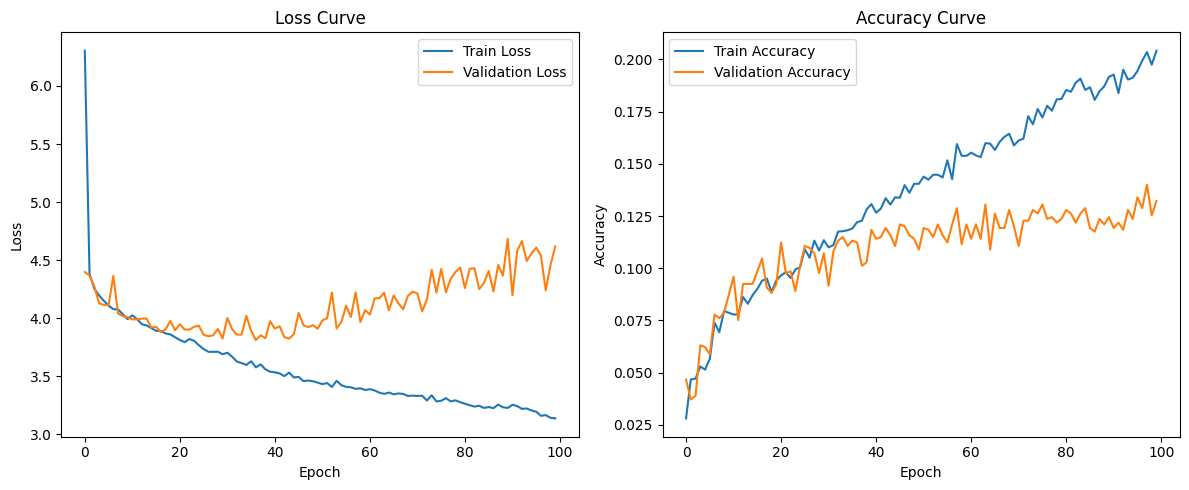

In [8]:
train_losses, val_losses, train_accs, val_accs = train_model(num_epochs=100)

plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

### 2-2

CNN structure with layer norm

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes=102):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.ln1 = nn.LayerNorm([32, 128, 128])
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.ln2 = nn.LayerNorm([64, 64, 64])

        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*32*32, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.ln1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.ln2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.fc(x)

        return x
    
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train the model feature layer norm

Epoch 1/100 | Train Acc: 1.40% | Val Acc: 1.90%
Epoch 2/100 | Train Acc: 2.31% | Val Acc: 3.28%
Epoch 3/100 | Train Acc: 3.05% | Val Acc: 3.28%
Epoch 4/100 | Train Acc: 3.00% | Val Acc: 3.28%
Epoch 5/100 | Train Acc: 3.05% | Val Acc: 3.28%
Epoch 6/100 | Train Acc: 2.96% | Val Acc: 3.28%
Epoch 7/100 | Train Acc: 2.72% | Val Acc: 3.28%
Epoch 8/100 | Train Acc: 3.07% | Val Acc: 3.37%
Epoch 9/100 | Train Acc: 3.11% | Val Acc: 3.37%
Epoch 10/100 | Train Acc: 2.96% | Val Acc: 3.37%
Epoch 11/100 | Train Acc: 3.20% | Val Acc: 3.37%
Epoch 12/100 | Train Acc: 3.20% | Val Acc: 3.37%
Epoch 13/100 | Train Acc: 3.20% | Val Acc: 3.37%
Epoch 14/100 | Train Acc: 3.20% | Val Acc: 3.37%
Epoch 15/100 | Train Acc: 3.20% | Val Acc: 3.37%
Epoch 16/100 | Train Acc: 3.20% | Val Acc: 3.37%
Epoch 17/100 | Train Acc: 3.20% | Val Acc: 3.37%
Epoch 18/100 | Train Acc: 3.20% | Val Acc: 3.37%
Epoch 19/100 | Train Acc: 3.20% | Val Acc: 3.37%
Epoch 20/100 | Train Acc: 3.20% | Val Acc: 3.37%
Epoch 21/100 | Train Acc: 3.2

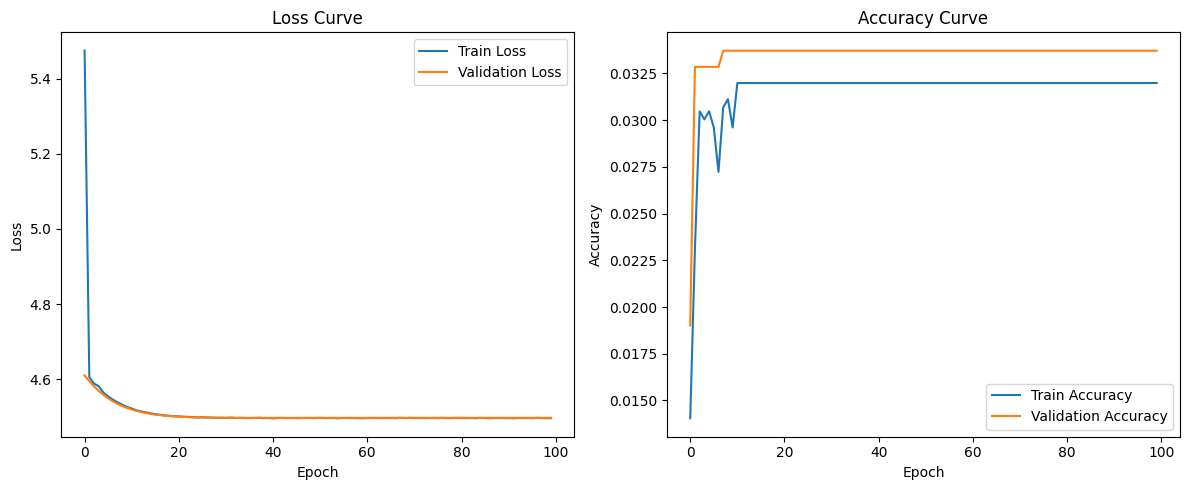

In [15]:
train_losses, val_losses, train_accs, val_accs = train_model(num_epochs=100)

plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

#### problem 2-2 discussion

##### Result comparison

- **BatchNorm significantly outperforms LayerNorm** on both training and validation accuracy.

- LayerNorm model is nearly random-guessing, suggesting the model failed to learn meaningful patterns.

##### Training comparision

- **BatchNorm** shows effective learning:

    - Loss decreased.

    - Accuracy increased steadily.

- **LayerNorm** shows no real learning:

    - Loss remained high.

    - Accuracy stuck at baseline (~3%), both on train and validation.

    This suggests that **BatchNorm helped stablize and speed up learning**, while LayerNorm was ineffective in this CNN task.

##### BatchNorm v.s LayerNorm

- **BatchNorm**

    - **Normalizes across batch**: Captures meaningful stats (mean/std) across many samples which is great for image data.

    - **Enhances generalization**: Acts as regularizer, improves convergence.

- **LayerNorm**

    - **Normalizes within each image**: Can disrupt spatial coherence in images. Each sample is normalized independently, removing meaningful variation across samples.

    - **No batch effect**: LayerNorm misses out on the stabilizing effect of batch statistics.

    - **Not suitable for CNNs**: LayerNorm is typically used in NLP and sequential models (Transformers, RNNs).

##### Conclusion

- **BatchNorm is clearly the better choice** for CNNs applied to image datasets.

- **LayerNorm is not effective** in this task, likely harms feature representation by disrupting the spatial and channel-wise structure in images.

### 2-3

#### (a) Construct ResNet-18

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=102):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels*block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*block.expansion)
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
def ResNet18(num_classes=102):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

model = ResNet18(num_classes=102).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train the model

Epoch 1/100 | Train Loss: 3.9308 | Val Loss: 3.6990 | Train Acc: 10.00% | Val Acc: 12.62%
Epoch 2/100 | Train Loss: 3.2420 | Val Loss: 3.7756 | Train Acc: 18.95% | Val Acc: 13.05%
Epoch 3/100 | Train Loss: 2.9861 | Val Loss: 4.1031 | Train Acc: 22.69% | Val Acc: 13.92%
Epoch 4/100 | Train Loss: 2.6946 | Val Loss: 2.9705 | Train Acc: 28.82% | Val Acc: 25.50%
Epoch 5/100 | Train Loss: 2.4488 | Val Loss: 4.9965 | Train Acc: 34.62% | Val Acc: 15.47%
Epoch 6/100 | Train Loss: 2.1829 | Val Loss: 3.8394 | Train Acc: 40.30% | Val Acc: 21.78%
Epoch 7/100 | Train Loss: 2.0393 | Val Loss: 2.3135 | Train Acc: 43.78% | Val Acc: 41.92%
Epoch 8/100 | Train Loss: 1.7782 | Val Loss: 2.3389 | Train Acc: 49.87% | Val Acc: 39.84%
Epoch 9/100 | Train Loss: 1.5556 | Val Loss: 2.4913 | Train Acc: 55.10% | Val Acc: 39.24%
Epoch 10/100 | Train Loss: 1.3808 | Val Loss: 2.5735 | Train Acc: 60.00% | Val Acc: 39.33%
Epoch 11/100 | Train Loss: 1.1478 | Val Loss: 2.7267 | Train Acc: 66.16% | Val Acc: 37.77%
Epoch 12

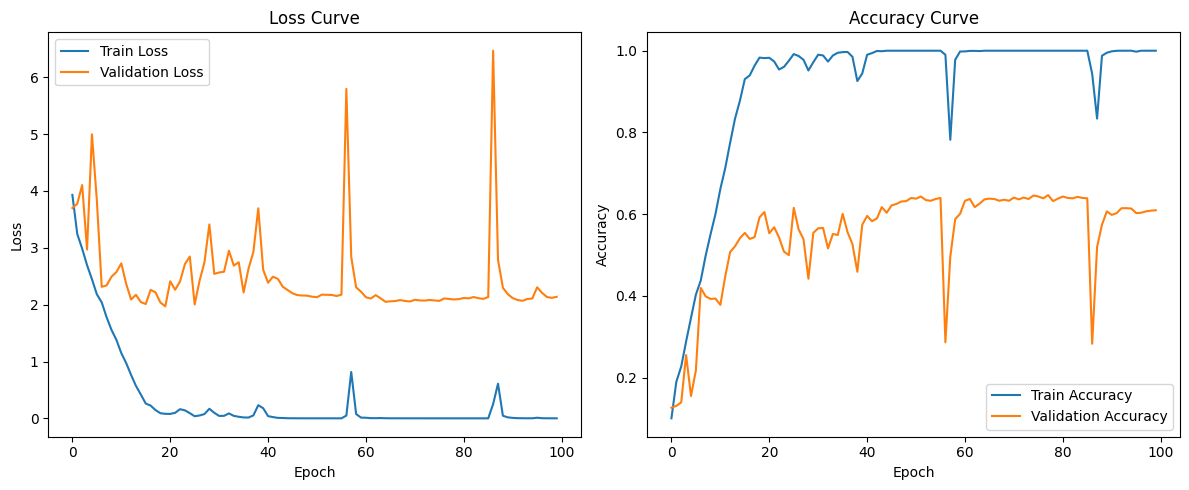

In [9]:
train_losses, val_losses, train_accs, val_accs = train_model(num_epochs=100)

plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

#### (b) remove identity mapping

model from 2-3(a) without identity mapping

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.relu(out)

        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=102):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = [block(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
def ResNet18(num_classes=102):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=102):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels*block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*block.expansion)
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
def ResNet18(num_classes=102):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

model = ResNet18(num_classes=102).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = ResNet18(num_classes=102).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train the model

Epoch 1/100 | Train Loss: 4.1641 | Val Loss: 4.1280 | Train Acc: 5.25% | Val Acc: 5.19%
Epoch 2/100 | Train Loss: 3.8488 | Val Loss: 3.7907 | Train Acc: 8.17% | Val Acc: 7.95%
Epoch 3/100 | Train Loss: 3.6606 | Val Loss: 3.6953 | Train Acc: 10.35% | Val Acc: 10.03%
Epoch 4/100 | Train Loss: 3.5010 | Val Loss: 3.6990 | Train Acc: 12.36% | Val Acc: 10.37%
Epoch 5/100 | Train Loss: 3.3628 | Val Loss: 4.3530 | Train Acc: 15.41% | Val Acc: 5.88%
Epoch 6/100 | Train Loss: 3.2261 | Val Loss: 4.1606 | Train Acc: 17.20% | Val Acc: 7.95%
Epoch 7/100 | Train Loss: 3.0742 | Val Loss: 3.4164 | Train Acc: 20.03% | Val Acc: 12.96%
Epoch 8/100 | Train Loss: 2.9397 | Val Loss: 4.1914 | Train Acc: 22.45% | Val Acc: 9.25%
Epoch 9/100 | Train Loss: 2.7933 | Val Loss: 3.2228 | Train Acc: 25.52% | Val Acc: 21.00%
Epoch 10/100 | Train Loss: 2.6367 | Val Loss: 2.7106 | Train Acc: 28.87% | Val Acc: 29.30%
Epoch 11/100 | Train Loss: 2.5141 | Val Loss: 3.0903 | Train Acc: 32.45% | Val Acc: 23.08%
Epoch 12/100 | 

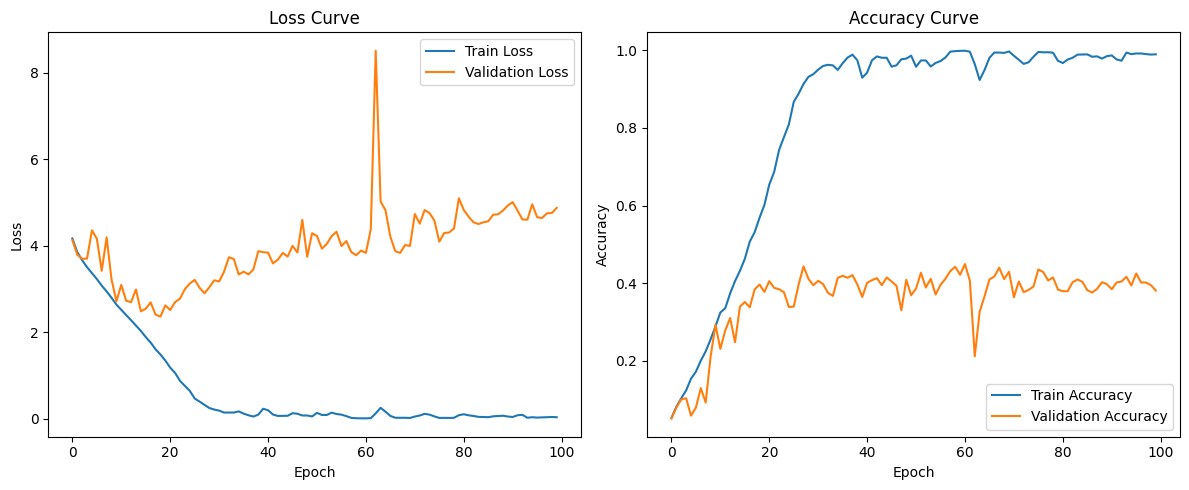

In [16]:
train_losses, val_losses, train_accs, val_accs = train_model(num_epochs=100)

plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

#### comparison and discussion (ResNet18: identity mapping v.s no identity mapping)

##### Result Summary

- With identity mapping: Train Accuracy: 100%, Validation Accuracy: ~60%

- Without identity mapping: Train Accuracy: 98.98%, Validation Accuracy: ~40%

    Both models achieve **very high training accuracy** (almost 99-100%), which means **both have sufficient capacity to fit the training data**.

    Slightly better training accuracy with identity mapping suggests **better optimization**, likely due to better gradient flow.

    **Validation accuracy of 60% from the model with identity mapping** indicates **better generalization** to unseen data.

    The **much lower validation accuracy of 40% from the model without identity mapping** suggests **overfitting**, poor generalization.

##### Identity mapping helps

- **Easier optimization**: identity shortcuts allow gradients to flow directly through the network.

- **Prevents degradation**: Deep networks without shortcuts can degrade (worse accuracy as depth grows).

- **Imporoved generalization**: Helps th emodle avoid overfitting by stabilizaing learning.

##### Problems without idengity mapping

- The model become **a plain deep CNN** with no shortcuts, making training harder.

- Can suffer from **vanishing gradients**, especially in deeper layers.

- Leads to **poor generalization**, as seen in the significant drop in validation accuracy.

##### Conclusion

- **Identity mapping (residual connections) is critical** in deep network structure.

- Identity mapping enables the network to **train deeper, converge faster**, and **generalize better**.

- Removing identity mapping results in a model that can still fit training data, but **generalizes poorly**, as evidenced by the 20% drop in validation accuracy.

## Problem 3

Datasets with data augmentation

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dir = "./flower/train"
test_dir = "./flower/test"

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.5, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random'),
])

val_test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

full_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size
train_indices, val_indices = torch.utils.data.random_split(
    range(len(full_dataset)), [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)

train_dataset.dataset.transform = train_transform  
val_dataset.dataset.transform = val_test_transform 

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class TestFlowerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith(".jpg")])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]
    
test_dataset = TestFlowerDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Construct ResNet18 and implement lr_scheduler

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=102):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(512*block.expansion, num_classes),
        )

    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels*block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*block.expansion)
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
def ResNet18(num_classes=102):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

model = ResNet18(num_classes=102).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

Train model function with lr schedule

In [43]:
def train_model(num_epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_losses.append(total_loss / len(train_loader))
        train_accs.append(correct / total)

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(correct / total)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_losses[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f} | "
              f"Train Acc: {train_accs[-1]*100:.2f}% | "
              f"Val Acc: {val_accs[-1]*100:.2f}%")
    
    return train_losses, val_losses, train_accs, val_accs

Train the model

Epoch 1/100 | Train Loss: 4.0349 | Val Loss: 3.6489 | Train Acc: 9.44% | Val Acc: 11.50%
Epoch 2/100 | Train Loss: 3.4374 | Val Loss: 3.2450 | Train Acc: 14.93% | Val Acc: 18.32%
Epoch 3/100 | Train Loss: 3.1204 | Val Loss: 3.3375 | Train Acc: 20.96% | Val Acc: 19.10%
Epoch 4/100 | Train Loss: 2.9022 | Val Loss: 3.1278 | Train Acc: 25.11% | Val Acc: 24.20%
Epoch 5/100 | Train Loss: 2.6257 | Val Loss: 3.1291 | Train Acc: 30.81% | Val Acc: 24.98%
Epoch 6/100 | Train Loss: 2.4441 | Val Loss: 2.6686 | Train Acc: 34.77% | Val Acc: 31.98%
Epoch 7/100 | Train Loss: 2.2388 | Val Loss: 2.8544 | Train Acc: 39.22% | Val Acc: 30.60%
Epoch 8/100 | Train Loss: 2.0207 | Val Loss: 2.2496 | Train Acc: 44.38% | Val Acc: 39.24%
Epoch 9/100 | Train Loss: 1.8671 | Val Loss: 2.4001 | Train Acc: 47.67% | Val Acc: 39.76%
Epoch 10/100 | Train Loss: 1.6416 | Val Loss: 2.2178 | Train Acc: 53.44% | Val Acc: 43.22%
Epoch 11/100 | Train Loss: 1.4891 | Val Loss: 2.1156 | Train Acc: 57.24% | Val Acc: 44.34%
Epoch 12/

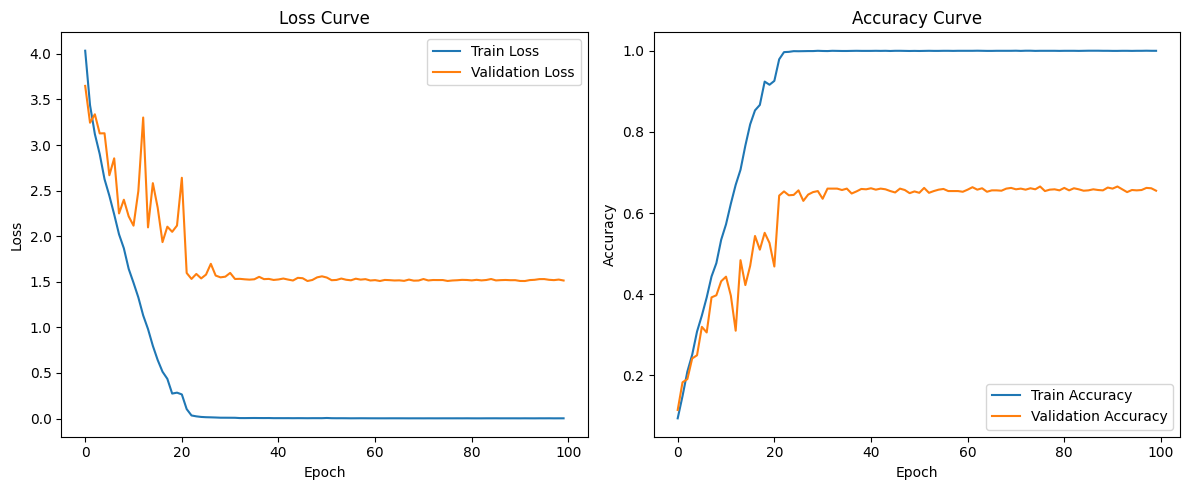

In [44]:
train_losses, val_losses, train_accs, val_accs = train_model(num_epochs=100)

plot_learning_curves(train_losses, val_losses, train_accs, val_accs)